# **Comparaison de Vision Transformer (ViT) à un CNN sur des images de style cartoons**
Ce notebook a été réalisé sous Google Colab. 

## **1. Importation des données**

### **1.1. Chargement des librairies**

In [ ]:
# Data manipulation
import numpy as np 
import pandas as pd 
import random

# Access files/directories
import os

# Copy files/directories content
import shutil

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Image manipulation
from PIL import Image

# Neuronal Network tools
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Dense, Input, GlobalAveragePooling2D)
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model

# sklearn tools
from sklearn.metrics import confusion_matrix, classification_report

# data persistence
import joblib

In [ ]:
# Access to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.2. Chargement des données**

Le dataset a été créé à partir d'images prises sur Google Image, à l'aide de tutoriels ([lien1](https://pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/), [lien2](https://medium.com/@bmrs2398/create-a-deep-learning-dataset-using-google-images-48654bd6ae96)).

Il a ensuite été chargé sur GoogleDrive.

In [ ]:
# Path to directory
images_dir_path = '/content/drive/My Drive/Formation/POC/Dataset'

# List of classes
list_classes = os.listdir(images_dir_path)

In [ ]:
list_classes

['Cat',
 'Tiger',
 'Panda',
 'Pengouin',
 'Flower',
 'Bird',
 'Tree',
 'Plane',
 'Dog',
 'Car']

In [ ]:
# Dictionnary to get for each classes the number of images 
dico_classes = {}

# Count total nb of images
nb_tot_img = 0

# Count number of classes
nb_classes = 0

for file in list_classes :
    
    # Count nb of classes
    nb_classes += 1
    
    # Get path to the class file
    file_path = os.path.join(images_dir_path, file)
    
    # Get breed name
    name_class = file
    
    # Initialize number of images
    nb_img = 0
    
    # For each "class file", get number of images
    for img in os.listdir(file_path) :
        nb_img += 1
        nb_tot_img += 1
        # Add to dictionnary
        dico_classes[name_class] = nb_img

print(dico_classes)
print("\nNumber of classes : ", nb_classes)
print("Total number of images : ", nb_tot_img)

{'Cat': 100, 'Tiger': 100, 'Panda': 100, 'Pengouin': 100, 'Flower': 100, 'Bird': 100, 'Tree': 100, 'Plane': 100, 'Dog': 100, 'Car': 100}

Number of classes :  10
Total number of images :  1000


Les images sont stockées dans le répertoire Dataset. Ensuite, il y a un répertoire par classe, nous comptons 10 classes au total. Chaque répertoire contient 100 images. 

## **2. Analyse des données**

### **2.1. Répartition du nombre d'images selon la classe**

In [ ]:
# Dataframe for classes information
df_classes = pd.DataFrame(data = dico_classes.values(), 
                        index = dico_classes.keys(),
                        columns = ["nb_images"]
                       )

<Figure size 864x576 with 0 Axes>

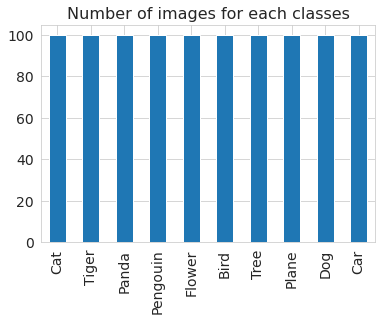

In [ ]:
# Plot classes numbers
fig = plt.figure(figsize=(12, 8))
df_classes.plot(kind="bar",
               legend=False,
               fontsize = 14)

plt.title("Number of images for each classes", fontsize=16)
plt.show()

### **2.2. Vérification du format des données**
Nous regardons si l'encodage est identique pour toutes les images, malgré un format commun .jpg. Nous cherchons à détecter les images au format .png qui sont de type RGBA. En effet, lorsque les images seront passées dans le modèle, elles doivent être du type RGB.

In [ ]:
list_png = []

for file in list_classes :
  # Get path to the class file
  file_path = os.path.join(images_dir_path, file)
    
  for img in os.listdir(file_path) :
    # Get image path
    img_path = os.path.join(file_path, img)

    if Image.open(img_path).format == 'PNG' :
      list_png.append(img_path)
       
print("Nombre d'images au format .png : ", len(list_png))

Nombre d'images au format .png :  211


Nous transformons les images .png (de type RGBA) en format "réel" .jpg (RGB) à l'aide de la fonction suivante.

In [ ]:
def pure_pil_alpha_to_color(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    Source: http://stackoverflow.com/a/9459208/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background

In [ ]:
# Conversion of the image in RGBA to RGB
for image_path in list_png : 
  img = Image.open(image_path).convert("RGBA")
  pure_pil_alpha_to_color(img).save(image_path)

Nous vérifions que la conversion a bien eu lieu.

In [ ]:
check_png = []

for file in list_classes :
  # Get path to the class file
  file_path = os.path.join(images_dir_path, file)
    
  for img in os.listdir(file_path) :
    # Get image path
    img_path = os.path.join(file_path, img)

    if Image.open(img_path).format == 'PNG' :
      check_png.append(img_path)
       
print("Nombre d'images au format .png : ", len(check_png))

Nombre d'images au format .png :  0


### **2.3. Visualisation des images**
**1 image par classe**

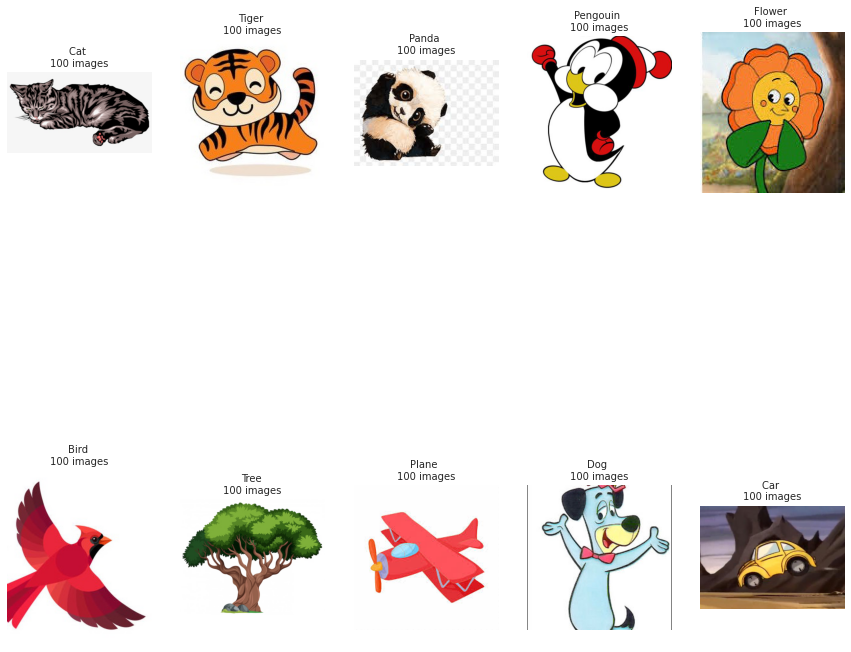

In [ ]:
# Display all classes with 1 image each and total number of images
plt.figure(figsize=(15, 15))

# Iniate counter
j = 0

# For each class
for i in range(10):
  # Subplot
  ax = plt.subplot(2, 5, j + 1)
  # Get class list of images
  images = os.listdir(images_dir_path + "/" + list_classes[i])
  plt.title("{} \n{} images".format(list_classes[i], 
            len(images)),
                 fontsize=10
            )
  # Random index
  x = np.random.randint(0, len(images))
  img = Image.open(
        images_dir_path + "/" + list_classes[i] +  "/" + images[x])
  j+=1
  plt.imshow(img)
  plt.axis("off")

**Plusieurs images d'une même classe**

Nous regardons au sein d'une même classe comment sont quelques images.

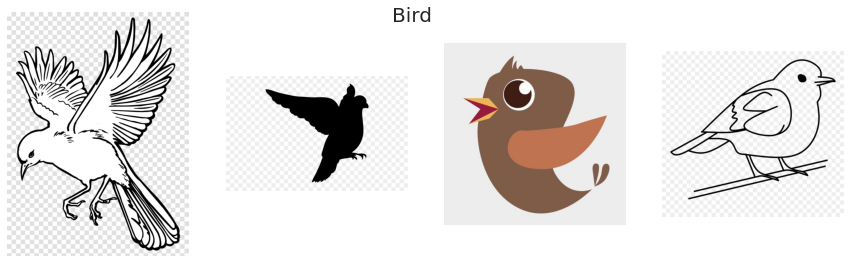

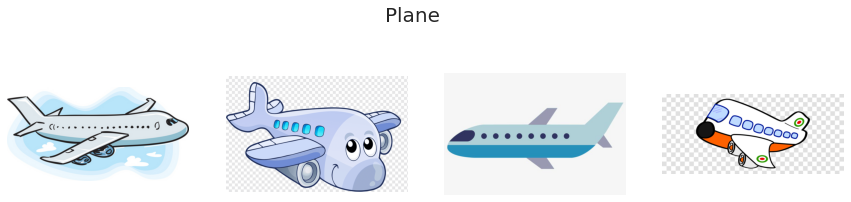

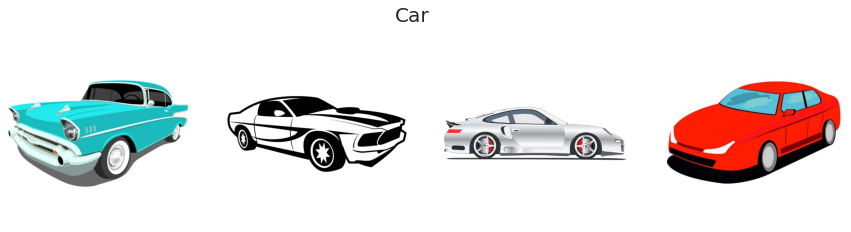

In [ ]:
# Display 3 random classes with 4 images each
for i in np.random.randint(0, len(list_classes), size=3):
    fig = plt.figure(figsize=(15,12))
    plt.suptitle("{}".format(list_classes[i]), 
                 fontsize=20, 
                 y = 0.65)
    
    # Get 4 images of breed list
    images = os.listdir(images_dir_path + "/" + list_classes[i])[:4]

    # Display 4 images
    for j in range(4):
        img = Image.open(images_dir_path + "/" + list_classes[i] +  "/" + images[j])
        plt.subplot(1, 4, j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


### **2.3. Effet du redimensionnement de l'image**
Nous constatons que les photos n'ont pas toutes la même taille. Or, lorsque les images vont être "injectées" dans le modèle, il faut que leurs tailles soient identiques. Nous devons donc les redimensionner.

Voyons cet effet sur une image test :

In [ ]:
# Image test
# Path to car file
car_file_path = images_dir_path + "/Car"

# List of images
list_car_img = os.listdir(car_file_path)

# Path to one image
car_img_path = os.path.join(car_file_path,list_car_img[0])

original_img = Image.open(car_img_path)

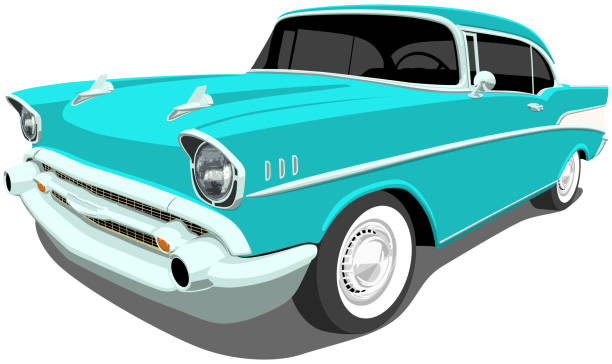

In [ ]:
original_img

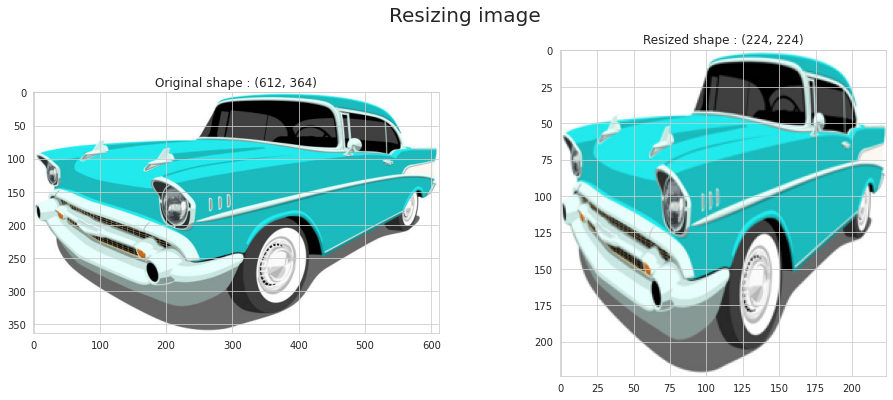

In [ ]:
# Setting dimension of the resize
SIZE = 224

# Resize image
resized_img = original_img.resize((SIZE, SIZE))

# Show both images
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original shape : {}".format(original_img.size))
plt.subplot(1, 2, 2)
plt.imshow(resized_img)
plt.title("Resized shape : {}".format(resized_img.size))
plt.suptitle("Resizing image",
             fontsize=20)
plt.show()

Le redimensionnement des images les déforme.

## **3. Data Augmentation**
Nous envisageons une data augmentation afin de fournir artificiellement plus d'images au modèle pour son apprentissage. 

Nous allons appliquer la data augmentation avec ImageDataGenerator. En effet, avec cette classe de la bibliothèque Keras, les images sont augmentées en direct ("online") lors de l’entraînement du réseau. Elles ne sont donc jamais sauvegardées en mémoire, et le réseau ne rencontre jamais deux fois la même image (car ces augmentations sont aléatoires). Cette méthode permet de s’assurer que le réseau voit des images variées à chaque epoch (cycle d’entraînement complet). 

Nous appliquons les effets suivants sur l'image précédente et les visualisons :
- effet miroir (horizontal_flip)
- rotation
- décalage (haut/bas et/ou droite/gauche)
- changement de luminosité
- zoom

In [ ]:
# Array
img_array = np.array(resized_img)
img_array = img_array.reshape((1,)+img_array.shape)

In [ ]:
def display_data_augmentation(datagen, img, img_array) :
  """
    Function to display effect of data augmentation on an image

    Arguments :
    - datagen : ImageDataGenerator
    - img : original image which has been resized
    - img_array : original image in array format

    Display :
    - 4 images : the original and three with data augmentation effect
  """
  # iterator
  aug_iter = datagen.flow(img_array, batch_size=1)

  # generate samples and plot
  fig = plt.figure(figsize=(15,15))

  # display original image
  plt.subplot(1,4,1)
  plt.imshow(img)
  plt.title("Original Image")

  # generate batch of images
  for i in range(3):
    plt.subplot(1,4,i+2)
    # convert to unsigned integers
    image = next(aug_iter)[0].astype("uint8")
	  # plot image
    plt.imshow(image)
    plt.title("Augmented Image #{}".format(i+1))

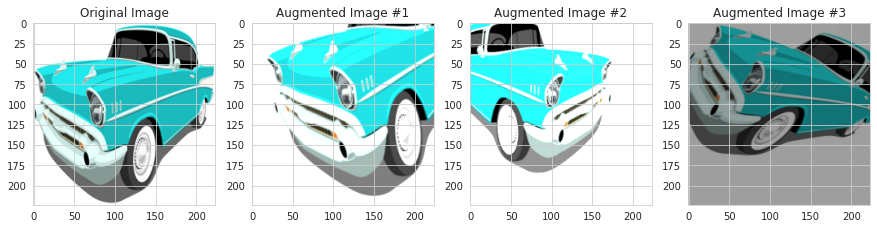

In [ ]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=45, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.25, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.5,1.5], # brightness
        ) 

# Display effects
display_data_augmentation(datagen, resized_img, img_array)

## **4. Split des données**
Afin d'effectuer les différents tests de modèles, nous allons splitter les données (les images) en : 80% Train/Validation et 20% Test, avec 65% Train et 15% Validation (par rapport au dataset global).

Nous créons d'abord les répertoires destinataires.

In [ ]:
project_path = "/content/drive/My Drive/Formation/POC"

sets_dir_path = project_path + "/Sets"
os.makedirs(sets_dir_path, exist_ok=True)

train_path = sets_dir_path + "/TrainSet"
os.makedirs(train_path, exist_ok=True)

validation_path = sets_dir_path + "/ValidationSet"
os.makedirs(validation_path, exist_ok=True)

test_path = sets_dir_path + "/TestSet"
os.makedirs(test_path, exist_ok=True)

Nous répartissons les images dans les différents répertoires pour créer les datasets.

In [ ]:
# Initiate size of datasets
train_size = 0
validation_size = 0
test_size = 0

for file in list_classes :
    
    # Get path to the class file
    file_path = os.path.join(images_dir_path, file)
    
    # Create path access and directory for each dataset
    class_train_path = os.path.join(train_path, file)
    os.makedirs(class_train_path, exist_ok=True)
    class_validation_path = os.path.join(validation_path, file)
    os.makedirs(class_validation_path, exist_ok=True)
    class_test_path = os.path.join(test_path, file)
    os.makedirs(class_test_path, exist_ok=True)
    
    # Get list of images
    list_img = os.listdir(file_path)
    
    # Shuffle list
    random.shuffle(list_img)
    
    # List of images for each dataset
    training_set = list_img[0:70]
    validation_set = list_img[70:85]
    test_set = list_img[85:len(list_img)]
    
    # For each "train_set", get number of images = train_size
    # and copy it in right directory
    for img in training_set :
        train_size += 1
        # Copy image in folder
        source = os.path.join(file_path, img)
        destination = os.path.join(class_train_path, img)
        dest = shutil.copy(source, destination)
    
    # For each "validation_set", get number of images = validation_size
    # and copy it in right directory
    for img in validation_set :
        validation_size += 1
        # Copy image in folder
        source = os.path.join(file_path, img)
        destination = os.path.join(class_validation_path, img)
        dest = shutil.copy(source, destination)

    # For each "test_set", get number of images = test_size
    # and copy it in right directory
    for img in test_set :
        test_size += 1
        # Copy image in folder
        source = os.path.join(file_path, img)
        destination = os.path.join(class_test_path, img)
        dest = shutil.copy(source, destination)

print("Number of images in train set : ",train_size)
print("Number of images in validation set : ",validation_size)
print("Number of images in test set : ",test_size)

# Check if every image has been affected to a dataset
if (train_size + validation_size + test_size) == nb_tot_img :
    print("\nImages distribution is successful")
else :
    print("Bad distribution, retry")

Number of images in train set :  700
Number of images in validation set :  150
Number of images in test set :  150

Images distribution is successful


## **5. MobileNetV2**
Dans cette partie, nous utilisons MobileNetV2 déjà entrainé sur ImageNet.

Dans un premier temps, nous modifions les dernières couches pour l'adapter à notre problème.

### **5.1. Transfer Learning**

#### **Importation du modèle**

In [ ]:
tf.keras.backend.clear_session()

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# Model importation without fully connected layers
imported_MobileNetV2 = MobileNetV2(weights="imagenet", 
                                   include_top=False, 
                                   input_shape=(224,224,3))

# Freeze model
imported_MobileNetV2.trainable = False

imported_MobileNetV2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

#### **Ajout des dernières couches**

In [ ]:
nb_classes = 10

inputs = keras.Input(shape=(224, 224, 3))

# As model gets BatchNorm layers, we make sure that the imported_MobileNetV2
# is running in inference mode here, by passing `training=False`. 
# This is important for fine-tuning
x = imported_MobileNetV2(inputs, training=False)

# Convert the feature vector into a 1280 element vector
x = GlobalAveragePooling2D()(x)
# last fully-connected layer to classify the 10 classes
predictions = Dense(nb_classes, activation='softmax')(x)

# Model Building
model_MobileNetV2 = Model(inputs = inputs, outputs = predictions)

model_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


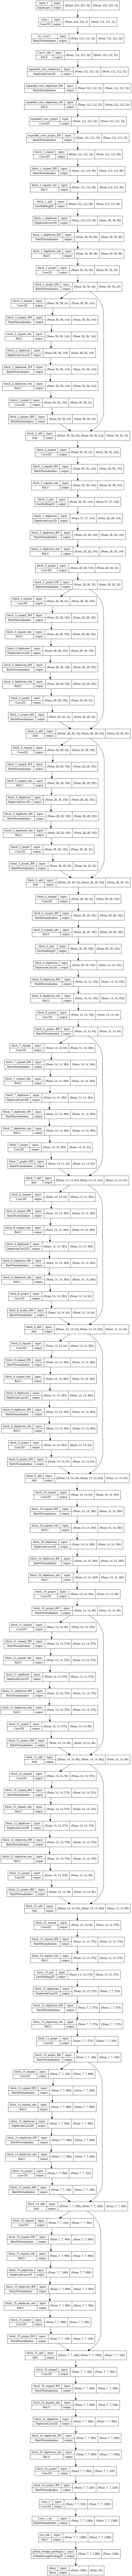

In [ ]:
my_img_path = project_path + "/my_images"
os.makedirs(my_img_path, exist_ok=True)

# Save this architecture as an image 
tf.keras.utils.plot_model(model_MobileNetV2, 
                          my_img_path + "/model_MobileNetV2_1.png", 
                          show_shapes=True)

#### **Compilation du modèle**

In [ ]:
# Model compilation
model_MobileNetV2.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              metrics=["accuracy"])

#### **Callbacks**

In [ ]:
models_path = project_path + "/models"
os.makedirs(models_path, exist_ok=True)

# File to save model
model_file_path = models_path + "/model_MobileNetV2_1_bis.h5"

# Checkpoint
checkpoint = ModelCheckpoint(filepath = model_file_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='max')

# Early stop
early_stop = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='max',
                      restore_best_weights = True)

#### **Pré-traitements des images**

In [ ]:
SIZE = 224

BATCH_SIZE = 32

# ImageDataGenerator
datagen_train = ImageDataGenerator(rotation_range=45, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        zoom_range=0.25, 
        horizontal_flip=True, 
        brightness_range=[0.5,1.5],
        preprocessing_function=preprocess_input)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                   
# Create iterator for trainset
train_iterator = datagen_train.flow_from_directory(train_path,
                                              target_size=(SIZE,SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle = True,
                                              seed = 42)

# Create iterator for validationset
validation_iterator = datagen.flow_from_directory(validation_path,
                                          target_size=(SIZE,SIZE),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical',
                                          shuffle = True,
                                          seed = 42)

Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


#### **Entrainement du modèle**

In [ ]:
%%time

epochs = 50

train_size = 700
validation_size = 150

history_mob = model_MobileNetV2.fit(
                train_iterator,
                steps_per_epoch = train_size // BATCH_SIZE, 
                epochs=epochs,
                validation_data=validation_iterator,
                validation_steps = validation_size // BATCH_SIZE,
                callbacks=[checkpoint, early_stop])

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.0970 - accuracy: 0.2904
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/My Drive/Formation/POC/models/model_MobileNetV2_1_bis.h5
21/21 [==============================] - 33s 1s/step - loss: 2.0970 - accuracy: 0.2904 - val_loss: 1.4879 - val_accuracy: 0.5000
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2355 - accuracy: 0.6257
Epoch 2: val_accuracy improved from 0.50000 to 0.71094, saving model to /content/drive/My Drive/Formation/POC/models/model_MobileNetV2_1_bis.h5
21/21 [==============================] - 31s 1s/step - loss: 1.2355 - accuracy: 0.6257 - val_loss: 0.9923 - val_accuracy: 0.7109
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.7725
Epoch 3: val_accuracy improved from 0.71094 to 0.74219, saving model to /content/drive/My Drive/Formation/POC/models/model_MobileNetV2_1_bis.h5
21/21 [========================

In [ ]:
# Convert the history.history dict to a pandas DataFrame 
hist_mob_df = pd.DataFrame(history_mob.history) 

# Save to csv
hist_mob_csv_file = models_path + "/history_MobileNetV2_1_bis.csv"
with open(hist_mob_csv_file, mode='w') as f:
    hist_mob_df.to_csv(f)

#### **Visualisation des résultats**

In [ ]:
def plot_learning_curve(history, model) :
  """
    Function to plot learning curve for accuracy and loss

    Arguments :
    - history
    - model : title of the plot, indicating type of model (string)

    Display :
    - 2 graphs : one for the accuray and the other one for the loss
  """

  # Figure initialisation
  f, axes = plt.subplots(figsize=(15, 8))

  # Accuracy visualization
  plt.subplot(121)
  plt.plot(history.history['accuracy'], label="Training Accuracy")
  plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()
  plt.title("{} Accuracy".format(model))

  # Loss visualization
  plt.subplot(122)
  plt.plot(history.history['loss'], label="Training Loss")
  plt.plot(history.history['val_loss'], label="Validation Loss")
  plt.title("{} Loss".format(model))
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

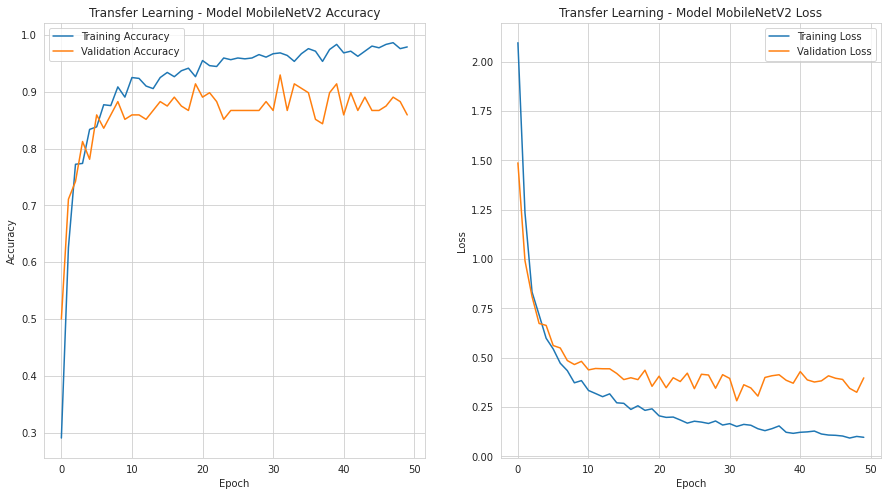

In [ ]:
plot_learning_curve(history_mob, "Transfer Learning - Model MobileNetV2")

#### **Evaluation du modèle**
Nous évaluons le modèle sur le jeu de test.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Create iterator for testset
test_iterator = datagen.flow_from_directory(test_path,
                                            target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle = False,
                                            seed = 42)

Found 150 images belonging to 10 classes.


In [ ]:
test_size = 150

model_MobileNetV2_eval = model_MobileNetV2.evaluate(test_iterator, 
                                          steps=test_size // BATCH_SIZE)
print("Loss on test set = ", model_MobileNetV2_eval[0])
print("Accuracy on test set = ",model_MobileNetV2_eval[1])

4/4 [==============================] - 2s 382ms/step - loss: 0.4453 - accuracy: 0.8750
Loss on test set =  0.4452590048313141
Accuracy on test set =  0.875


Nous créons un dataframe pour stocker les résultats des différents modèles.

In [ ]:
data = {"Model" : ["MobileNetV2"],
        "Nb epochs" : [len(hist_mob_df)],
        "Max Training Accuracy" : [round(np.max(hist_mob_df["accuracy"]),4)], 
        "Min Training Loss" : [round(np.min(hist_mob_df["loss"]),4)],
        "Max Validation Accuracy" : [round(np.max(hist_mob_df["val_accuracy"]),4)], 
        "Min Validation Loss" : [round(np.min(hist_mob_df["val_loss"]),4)],
        "Test Accuracy" : [round(model_MobileNetV2_eval[1],4)], 
        "Test Loss" : [round(model_MobileNetV2_eval[0],4)]}

In [ ]:
# Dataframe to get all results
df_results = pd.DataFrame(data, columns = ["Model", "Nb epochs",
                                           "Max Training Accuracy", 
                                     "Min Training Loss",
                                     "Max Validation Accuracy", 
                                     "Min Validation Loss",
                                     "Test Accuracy", "Test Loss"])
df_results

Model  Nb epochs  Max Training Accuracy  Min Training Loss  \
0  MobileNetV2         50                 0.9865             0.0932   

   Max Validation Accuracy  Min Validation Loss  Test Accuracy  Test Loss  
0                   0.9297                0.282          0.875     0.4453

### **5.2. Fine tuning**
Nous tentons d'améliorer le modèle en effectuant un fine tuning. D'après le [guide Keras sur le Transfer Learning](https://keras.io/guides/transfer_learning/), nous devons unfreeze les couches du modèle importé et ré-entrainé le modèle précédent sur notre dataset, avec un learning rate plus faible afin d'éviter l'overfitting rapidement.

In [ ]:
# Unfreeze the base model
imported_MobileNetV2.trainable = True

model_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


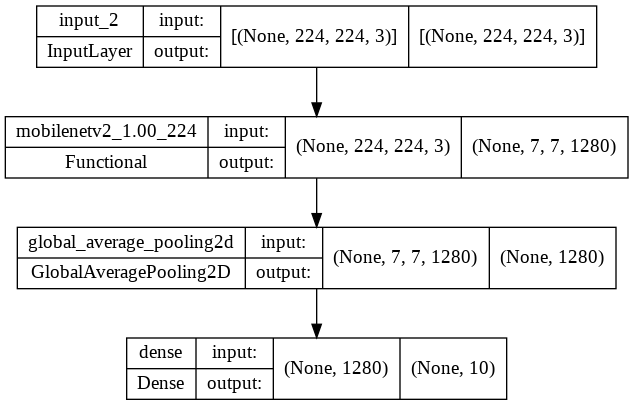

In [ ]:
# Save this architecture as an image 
tf.keras.utils.plot_model(model_MobileNetV2, 
                          my_img_path + "/model_MobileNetV2_2_bis.png", 
                          show_shapes=True)

#### **Compilation du modèle**

In [ ]:
# Model compilation with a low learning rate
model_MobileNetV2.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  
              metrics=["accuracy"])

#### **Callbacks**

In [ ]:
# File to save model
model_file_path = models_path + "/model_MobileNetV2_2_bis.h5"

# Checkpoint
checkpoint = ModelCheckpoint(filepath = model_file_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='max')

# Early stop
early_stop = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='max',
                      restore_best_weights = True)

#### **Entrainement du modèle**

In [ ]:
%%time

fine_tuned_epochs = 50
total_epochs = epochs + fine_tuned_epochs

history_mob_fine = model_MobileNetV2.fit(
                train_iterator,
                steps_per_epoch = train_size // BATCH_SIZE, 
                epochs=total_epochs,
                initial_epoch = history_mob.epoch[-1],
                validation_data=validation_iterator,
                validation_steps = validation_size // BATCH_SIZE,
                callbacks=[checkpoint, early_stop])

Epoch 50/100
21/21 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9731
Epoch 50: val_accuracy improved from -inf to 0.86719, saving model to /content/drive/My Drive/Formation/POC/models/model_MobileNetV2_2_bis.h5
21/21 [==============================] - 34s 1s/step - loss: 0.1057 - accuracy: 0.9731 - val_loss: 0.4208 - val_accuracy: 0.8672
Epoch 51/100
21/21 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9835
Epoch 51: val_accuracy improved from 0.86719 to 0.89062, saving model to /content/drive/My Drive/Formation/POC/models/model_MobileNetV2_2_bis.h5
21/21 [==============================] - 27s 1s/step - loss: 0.0641 - accuracy: 0.9835 - val_loss: 0.3300 - val_accuracy: 0.8906
Epoch 52/100
21/21 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9805
Epoch 52: val_accuracy did not improve from 0.89062
21/21 [==============================] - 25s 1s/step - loss: 0.0684 - accuracy: 0.9805 - val_loss: 0.4043 - val_acc

In [ ]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_mob_tuned = pd.DataFrame(history_mob_fine.history) 

# Save to csv
hist_mob_tuned_csv_file = models_path + "/history_MobileNetV2_2_bis.csv"
with open(hist_mob_tuned_csv_file, mode='w') as f:
    hist_df_mob_tuned.to_csv(f)

#### **Visualisation des résultats**

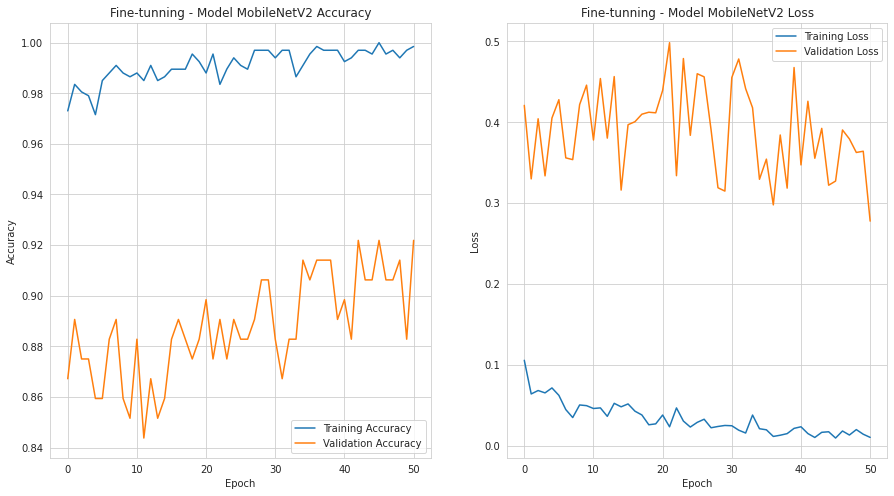

In [ ]:
plot_learning_curve(
    history_mob_fine, 
    "Fine-tunning - Model MobileNetV2"
    )

In [ ]:
models_path = project_path + "/models"

# Load history 
hist_mob_csv_file = models_path + "/history_MobileNetV2_1_bis.csv"
hist_mob_df = pd.read_csv(hist_mob_csv_file)

hist_mob_tuned_csv_file = models_path + "/history_MobileNetV2_2_bis.csv"
hist_df_mob_tuned = pd.read_csv(hist_mob_tuned_csv_file) 

In [ ]:
hist_mob_df_all = pd.concat([hist_mob_df,hist_df_mob_tuned]).reset_index(drop=True)

In [ ]:
hist_mob_df_all

Unnamed: 0      loss  accuracy  val_loss  val_accuracy
0             0  2.097041  0.290419  1.487904      0.500000
1             1  1.235483  0.625749  0.992285      0.710938
2             2  0.833131  0.772455  0.810799      0.742188
3             3  0.717475  0.773952  0.673794      0.812500
4             4  0.598860  0.833832  0.664148      0.781250
..          ...       ...       ...       ...           ...
96           46  0.018344  0.995509  0.390433      0.906250
97           47  0.013373  0.997006  0.379358      0.906250
98           48  0.020084  0.994012  0.362618      0.914062
99           49  0.014360  0.997006  0.364134      0.882812
100          50  0.010461  0.998503  0.277772      0.921875

[101 rows x 5 columns]

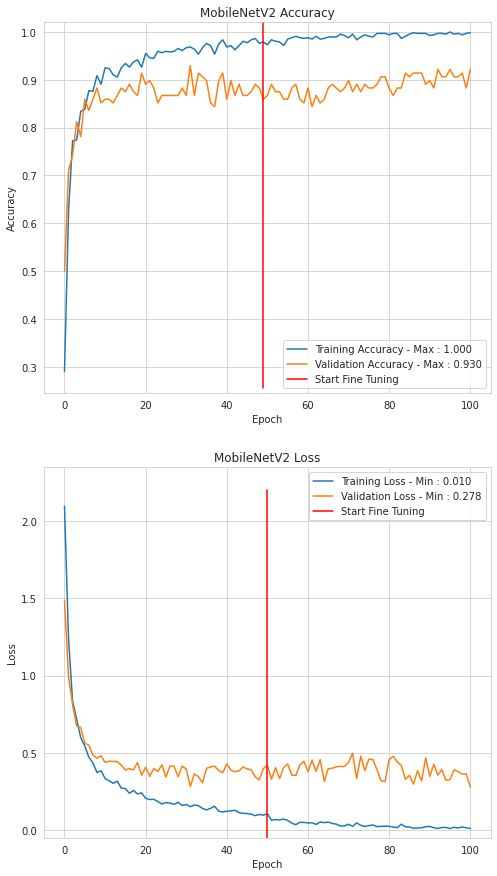

In [ ]:
# Figure initialisation
f, axes = plt.subplots(figsize=(8, 15))

# Accuracy visualization
plt.subplot(211)
plt.plot(hist_mob_df_all['accuracy'], 
         label="Training Accuracy - Max : {:.3f}".format(
             np.max(hist_mob_df_all['accuracy'])))
plt.plot(hist_mob_df_all['val_accuracy'], 
         label="Validation Accuracy - Max : {:.3f}".format(
         np.max(hist_mob_df_all['val_accuracy'])))
plt.plot([len(hist_mob_df)-1,len(hist_mob_df)-1],
          plt.ylim(), label='Start Fine Tuning', color ='r')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0.245, 1.02)
plt.legend()
plt.title("{} Accuracy".format("MobileNetV2"))

# Loss visualization
plt.subplot(212)
plt.plot(hist_mob_df_all['loss'], label="Training Loss - Min : {:.3f}".format(
    np.min(hist_mob_df_all['loss'])))
plt.plot(hist_mob_df_all['val_loss'], 
         label="Validation Loss - Min : {:.3f}".format(
         np.min(hist_mob_df_all['val_loss'])))
plt.plot([len(hist_mob_df),len(hist_mob_df)],
          plt.ylim(), label='Start Fine Tuning', color = 'r')
plt.title("{} Loss".format("MobileNetV2"))
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(-0.05, 2.35)
plt.legend()
plt.show()

#### **Evaluation du modèle**
Nous évaluons le modèle sur le jeu de test.

In [ ]:
# Create iterator for testset
test_iterator = datagen.flow_from_directory(test_path,
                                            target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle = False,
                                            seed = 42)

Found 150 images belonging to 10 classes.


In [ ]:
# Model evaluation
model_MobileNetV2_eval = model_MobileNetV2.evaluate(test_iterator, 
                                          steps=test_size // BATCH_SIZE)
print("Loss on test set = ", model_MobileNetV2_eval[0])
print("Accuracy on test set = ",model_MobileNetV2_eval[1])

4/4 [==============================] - 2s 395ms/step - loss: 0.4318 - accuracy: 0.9141
Loss on test set =  0.43183639645576477
Accuracy on test set =  0.9140625


In [ ]:
# Add results to dataframe 
df_results = df_results.append(pd.Series(["Fine tuned MobileNetV2",
                                          len(hist_df_mob_tuned),
                                          round(np.max(hist_df_mob_tuned["accuracy"]),4),
                                          round(np.min(hist_df_mob_tuned["loss"]),4),
                                          round(np.max(hist_df_mob_tuned["val_accuracy"]),4),
                                          round(np.min(hist_df_mob_tuned["val_loss"]),4),
                                          round(model_MobileNetV2_eval[1],4),
                                          round(model_MobileNetV2_eval[0],4)],
                                         index=df_results.columns), 
                               ignore_index=True)
                              
df_results

Model  Nb epochs  Max Training Accuracy  \
0             MobileNetV2         50                 0.9865   
1  Fine tuned MobileNetV2         51                 1.0000   

   Min Training Loss  Max Validation Accuracy  Min Validation Loss  \
0             0.0932                   0.9297               0.2820   
1             0.0097                   0.9219               0.2778   

   Test Accuracy  Test Loss  
0         0.8750     0.4453  
1         0.9141     0.4318

## **6. Vision Transformer (ViT)** 




### **6.1. Installation des librairies**

In [ ]:
!pip install -qq -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
!pip install --quiet vit-keras

In [ ]:
from vit_keras import vit

### **6.2. Visualisation d'une image par patch**
A l'aide du [code suivant](https://analyticsindiamag.com/hands-on-guide-to-using-vision-transformer-for-image-classification/), disponible aussi sur [Keras](https://keras.io/examples/vision/image_classification_with_vision_transformer/), nous visualisons une image splittée en patches, découpage utilisé par le ViT.

Nous utiliserons un modèle dans la suite avec des patches de taille 32.


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


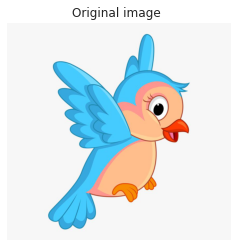

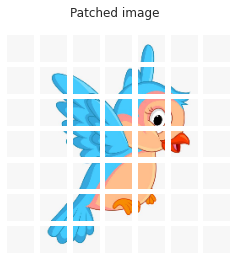

In [ ]:
patch_size = 32
SIZE = 224

# List of images
list_img = os.listdir(train_path + '/Bird')

# Path to one image
bird_img_path = os.path.join(train_path + '/Bird',
                             list_img[np.random.choice(range(len(list_img)))])

# Get image
bird_img = Image.open(bird_img_path)

# Display original image
plt.figure(figsize=(4, 4))
plt.title("Original image ")
plt.imshow(bird_img)
plt.axis("off")

# Array
img_array = np.array(bird_img)

# Tensor
resized_image = tf.image.resize(
    tf.convert_to_tensor([img_array]), size=(SIZE, SIZE)
)

# Get patches
patches = Patches(patch_size)(resized_image)
print(f"Image size: {SIZE} X {SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Display patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
plt.suptitle("Patched image")
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### **6.3. Transfer Learning**

#### **Importation du modèle**
Nous importons le modèle `vit_b32` et l'utilisons en nous aidant du [lien suivant](
https://github.com/faustomorales/vit-keras).

Nous enlèvons la dernière couche.

In [ ]:
tf.keras.backend.clear_session()

nb_classes = 10
SIZE = 224

imported_vit_model = vit.vit_b32(
        image_size = SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = nb_classes)

imported_vit_model.trainable = False

353263616/353253686 [==============================] - 17s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [ ]:
imported_vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

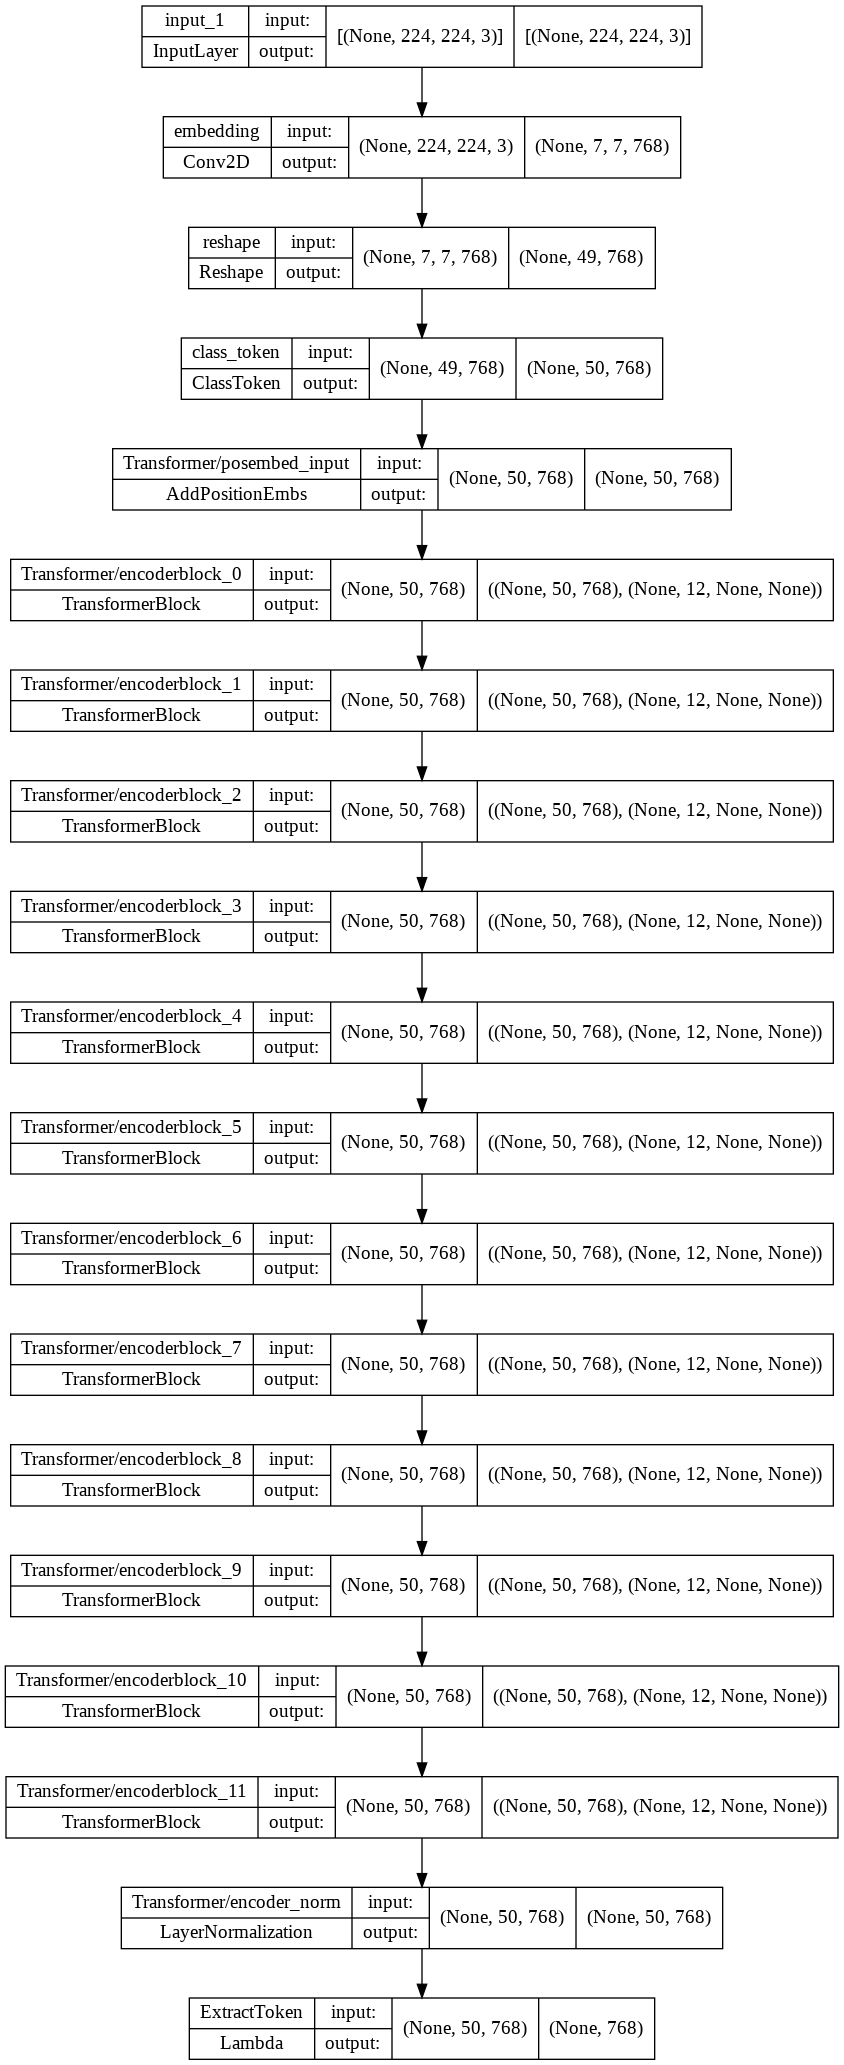

In [ ]:
# Save this architecture as an image 
tf.keras.utils.plot_model(imported_vit_model, 
                          my_img_path + "/model_ViT_1.png", 
                          show_shapes=True)

#### **Ajout de la dernière couche**
Nous ajoutons une couche dense pour effectuer la classification.

In [ ]:
model_vit = tf.keras.Sequential([
        imported_vit_model,
        tf.keras.layers.Dense(nb_classes, activation = 'softmax')
    ],
    name = 'vision_transformer')

model_vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 dense (Dense)               (None, 10)                7690      
                                                                 
Total params: 87,462,922
Trainable params: 7,690
Non-trainable params: 87,455,232
_________________________________________________________________


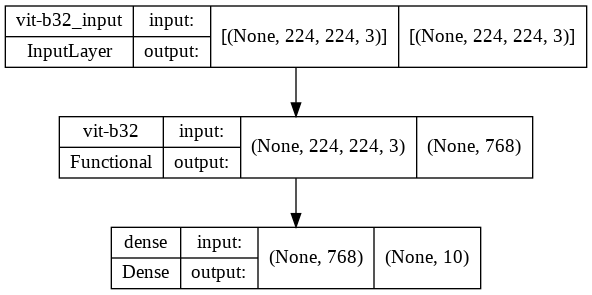

In [ ]:
# Save this architecture as an image 
tf.keras.utils.plot_model(model_vit, 
                          my_img_path + "/model_ViT_1_bis.png", 
                          show_shapes=True)

#### **Compilation du modèle**

In [ ]:
# Model compilation
model_vit.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              metrics=["accuracy"])

#### **Callbacks**

In [ ]:
# File to save model
models_path = project_path + "/models"
model_file_path = models_path + "/model_ViT_1.h5"

# Checkpoint
checkpoint = ModelCheckpoint(filepath = model_file_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='max')

# Early stop
early_stop = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='max',
                      restore_best_weights = True)

#### **Pré-traitements des images**

In [ ]:
# Image size
SIZE = 224

# Batch size
BATCH_SIZE = 32

# ImageDataGenerator
datagen_train = ImageDataGenerator(rotation_range=45, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        zoom_range=0.25, 
        horizontal_flip=True, 
        brightness_range=[0.5,1.5],
        fill_mode = "nearest",
        preprocessing_function = vit.preprocess_inputs)

datagen = ImageDataGenerator(preprocessing_function = vit.preprocess_inputs)
                                   
# Create iterator for trainset
train_iterator = datagen_train.flow_from_directory(train_path,
                                              target_size=(SIZE,SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle = True,
                                              seed = 42)

# Create iterator for validationset
validation_iterator = datagen.flow_from_directory(validation_path,
                                          target_size=(SIZE,SIZE),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical',
                                          shuffle = True,
                                          seed = 42)

Found 700 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


#### **Entrainement du modèle**

In [ ]:
%%time

epochs = 50

train_size = 700
validation_size = 150

history = model_vit.fit(
                train_iterator,
                steps_per_epoch = train_size // BATCH_SIZE, 
                epochs=epochs,
                validation_data=validation_iterator,
                validation_steps = validation_size // BATCH_SIZE,
                callbacks=[checkpoint, early_stop])

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.3161 - accuracy: 0.2515 
Epoch 1: val_accuracy improved from -inf to 0.55469, saving model to /content/drive/My Drive/Formation/POC/models/model_ViT_1.h5
21/21 [==============================] - 523s 24s/step - loss: 2.3161 - accuracy: 0.2515 - val_loss: 1.3488 - val_accuracy: 0.5547
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2567 - accuracy: 0.5988
Epoch 2: val_accuracy improved from 0.55469 to 0.71094, saving model to /content/drive/My Drive/Formation/POC/models/model_ViT_1.h5
21/21 [==============================] - 29s 1s/step - loss: 1.2567 - accuracy: 0.5988 - val_loss: 0.8029 - val_accuracy: 0.7109
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.7231
Epoch 3: val_accuracy improved from 0.71094 to 0.78906, saving model to /content/drive/My Drive/Formation/POC/models/model_ViT_1.h5
21/21 [==============================] - 28s 1s/step - loss: 0.8

In [ ]:
# Convert the history.history dict to a pandas DataFrame 
hist_df = pd.DataFrame(history.history) 

# Save to csv
hist_csv_file = models_path + "/history_ViT_1.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#### **Visualisation des résultats**

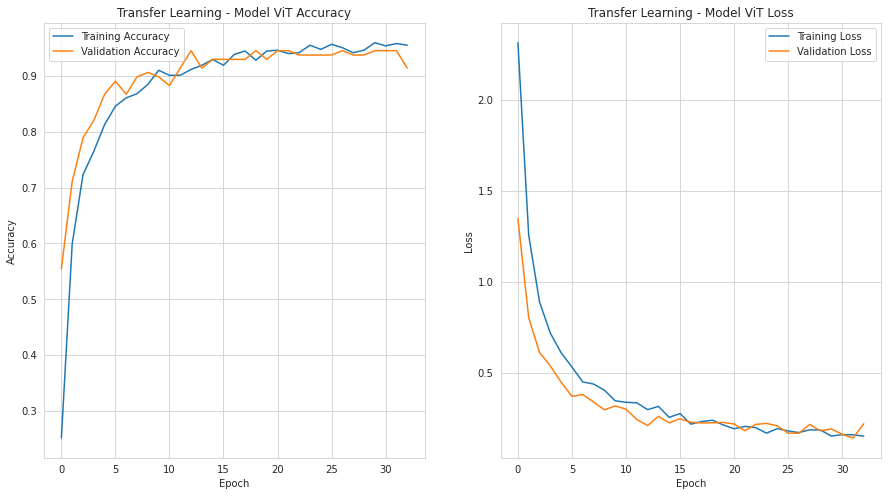

In [ ]:
plot_learning_curve(
    history, 
    "Transfer Learning - Model ViT"
    )

#### **Evaluation du modèle**
Nous évaluons le modèle sur le jeu de test.

In [ ]:
datagen = ImageDataGenerator(preprocessing_function = vit.preprocess_inputs)

In [ ]:
# Create iterator for testset
test_iterator = datagen.flow_from_directory(test_path,
                                            target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle = False,
                                            seed = 42)

Found 150 images belonging to 10 classes.


In [ ]:
# Model evaluation

test_size = 150

model_vit_eval = model_vit.evaluate(test_iterator, 
                                          steps=test_size // BATCH_SIZE)
print("Loss on test set = ", model_vit_eval[0])
print("Accuracy on test set = ",model_vit_eval[1])

4/4 [==============================] - 6s 483ms/step - loss: 0.3295 - accuracy: 0.9219
Loss on test set =  0.32952213287353516
Accuracy on test set =  0.921875


In [ ]:
# Load history 
hist_csv_file = models_path + "/history_ViT_1.csv"
hist_df = pd.read_csv(hist_csv_file)

In [ ]:
# Add results to dataframe 
df_results = df_results.append(pd.Series(["ViT",
                                          len(hist_df),
                                          round(np.max(hist_df["accuracy"]),4),
                                          round(np.min(hist_df["loss"]),4),
                                          round(np.max(hist_df["val_accuracy"]),4),
                                          round(np.min(hist_df["val_loss"]),4),
                                          round(model_vit_eval[1],4),
                                          round(model_vit_eval[0],4)],
                                         index=df_results.columns), 
                               ignore_index=True)
                              
df_results

Model  Nb epochs  Max Training Accuracy  \
0             MobileNetV2         50                 0.9865   
1  Fine tuned MobileNetV2         51                 1.0000   
2                     ViT         33                 0.9596   

   Min Training Loss  Max Validation Accuracy  Min Validation Loss  \
0             0.0932                   0.9297               0.2820   
1             0.0097                   0.9219               0.2778   
2             0.1528                   0.9453               0.1420   

   Test Accuracy  Test Loss  
0         0.8750     0.4453  
1         0.9141     0.4318  
2         0.9219     0.3295

In [ ]:
# Save this dataframe 
filename = models_path + '/df_results_bis.joblib'
joblib.dump(df_results, filename)

['/content/drive/My Drive/Formation/POC/models/df_results_bis.joblib']

### **6.4. Fine-tuning** 

In [ ]:
# Unfreeze the base model
imported_vit_model.trainable = True

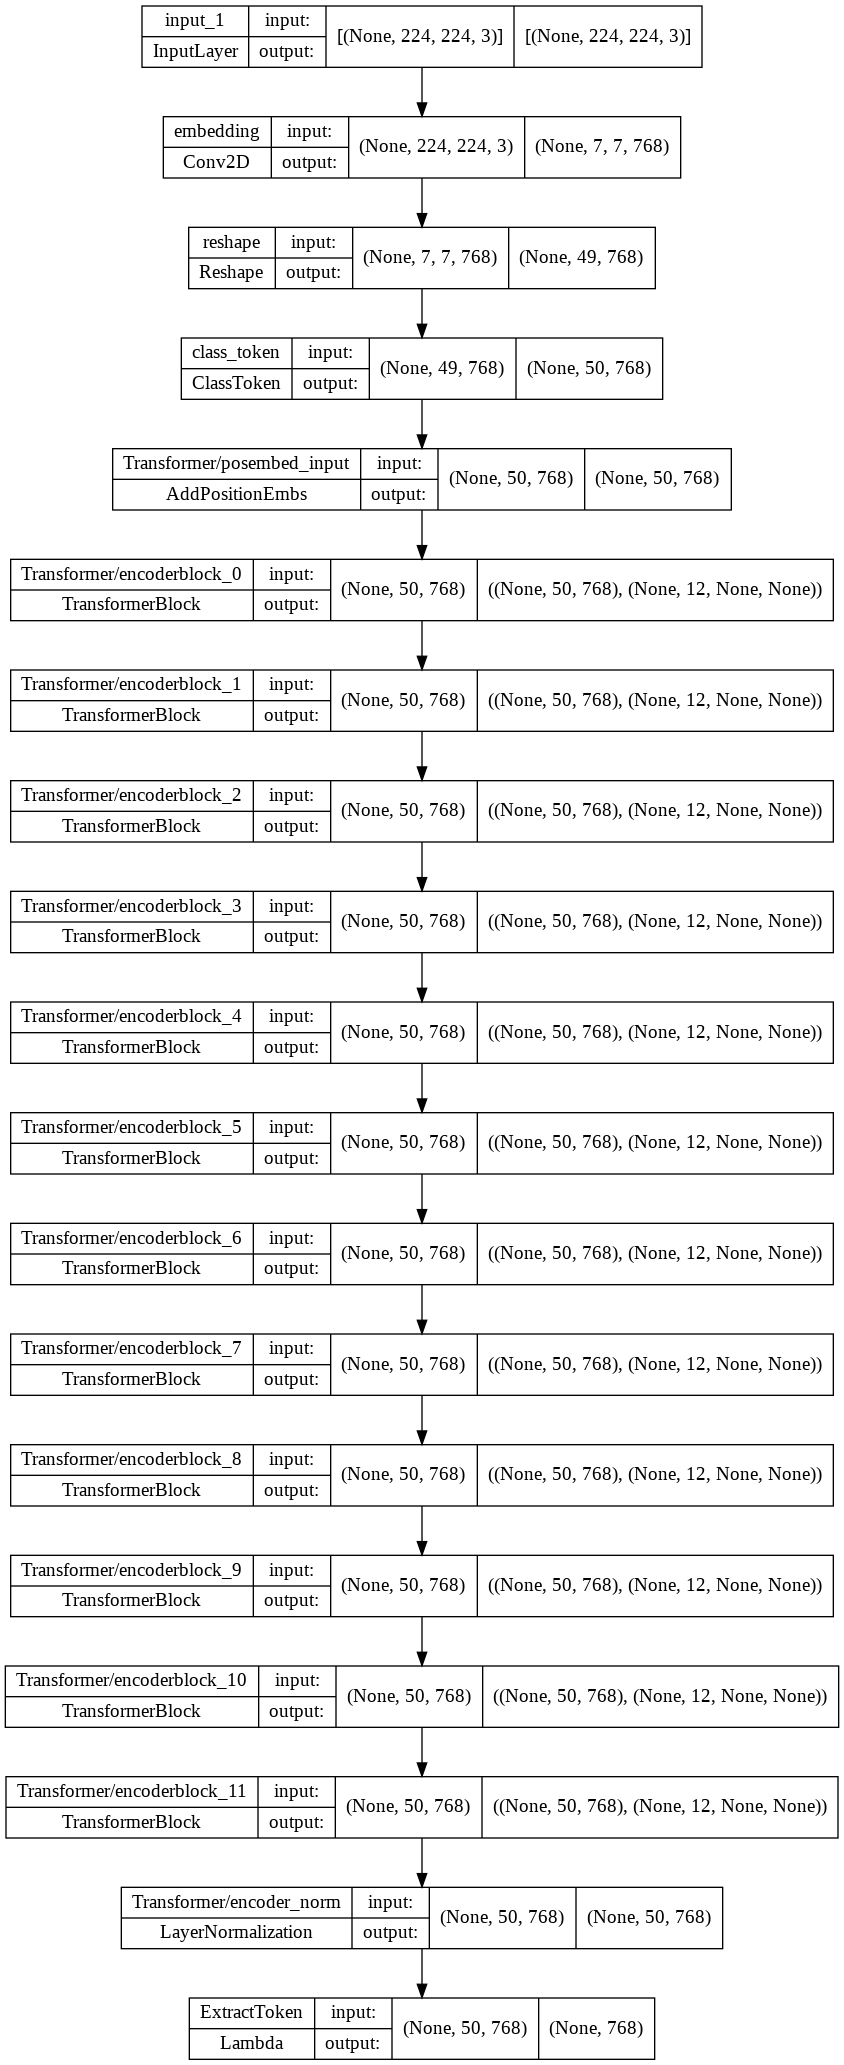

In [ ]:
# Save this architecture as an image 
tf.keras.utils.plot_model(imported_vit_model, 
                          my_img_path + "/model_ViT_2.png", 
                          show_shapes=True)

#### **Compilation du modèle**

In [ ]:
# Model compilation with a low learning rate
model_vit.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  
              metrics=["accuracy"])

In [ ]:
model_vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 dense (Dense)               (None, 10)                7690      
                                                                 
Total params: 87,462,922
Trainable params: 87,462,922
Non-trainable params: 0
_________________________________________________________________


#### **Callbacks**

In [ ]:
# File to save model
model_file_path = models_path + "/model_ViT_2_bis.h5"

# Checkpoint
checkpoint = ModelCheckpoint(filepath = model_file_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='max')

# Early stop
early_stop = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='max',
                      restore_best_weights = True)

#### **Entrainement du modèle**

In [ ]:
%%time

fine_tuned_epochs = 50
total_epochs = epochs + fine_tuned_epochs

history_fine = model_vit.fit(
                train_iterator,
                steps_per_epoch = train_size // BATCH_SIZE, 
                epochs=total_epochs,
                initial_epoch = history.epoch[-1],
                validation_data=validation_iterator,
                validation_steps = validation_size // BATCH_SIZE,
                callbacks=[checkpoint, early_stop])

Epoch 33/100
21/21 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9296
Epoch 33: val_accuracy improved from -inf to 0.92188, saving model to /content/drive/My Drive/Formation/POC/models/model_ViT_2_bis.h5
21/21 [==============================] - 70s 2s/step - loss: 0.2591 - accuracy: 0.9296 - val_loss: 0.2364 - val_accuracy: 0.9219
Epoch 34/100
21/21 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9521
Epoch 34: val_accuracy improved from 0.92188 to 0.93750, saving model to /content/drive/My Drive/Formation/POC/models/model_ViT_2_bis.h5
21/21 [==============================] - 39s 2s/step - loss: 0.2118 - accuracy: 0.9521 - val_loss: 0.1990 - val_accuracy: 0.9375
Epoch 35/100
21/21 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9386
Epoch 35: val_accuracy improved from 0.93750 to 0.96875, saving model to /content/drive/My Drive/Formation/POC/models/model_ViT_2_bis.h5
21/21 [==============================] - 52s 3

In [ ]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_tuned = pd.DataFrame(history_fine.history) 

# Save to csv
hist_tuned_csv_file = models_path + "/history_ViT_2_bis.csv"
with open(hist_tuned_csv_file, mode='w') as f:
    hist_df_tuned.to_csv(f)

#### **Visualisation des résultats**

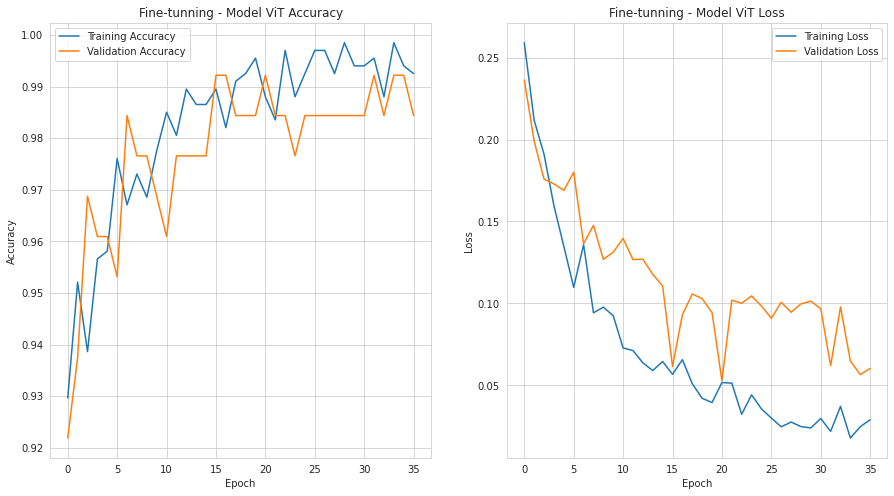

In [ ]:
plot_learning_curve(
    history_fine, 
    "Fine-tunning - Model ViT"
    )

In [ ]:
# Load history 
hist_vit_csv_file = models_path + "/history_ViT_1.csv"
hist_vit_df = pd.read_csv(hist_vit_csv_file)

hist_vit_tuned_csv_file = models_path + "/history_ViT_2_bis.csv"
hist_df_vit_tuned = pd.read_csv(hist_vit_tuned_csv_file) 

In [ ]:
hist_vit_df_all = pd.concat([hist_vit_df,hist_df_vit_tuned]).reset_index(drop=True)
hist_vit_df_all

Unnamed: 0      loss  accuracy  val_loss  val_accuracy
0            0  2.316077  0.251497  1.348790      0.554688
1            1  1.256697  0.598802  0.802852      0.710938
2            2  0.890611  0.723054  0.612935      0.789062
3            3  0.718674  0.764970  0.538118      0.820312
4            4  0.610884  0.812874  0.449030      0.867188
..         ...       ...       ...       ...           ...
64          31  0.021892  0.995509  0.061931      0.992188
65          32  0.037155  0.988024  0.097892      0.984375
66          33  0.017823  0.998503  0.064832      0.992188
67          34  0.024745  0.994012  0.056545      0.992188
68          35  0.028965  0.992515  0.060363      0.984375

[69 rows x 5 columns]

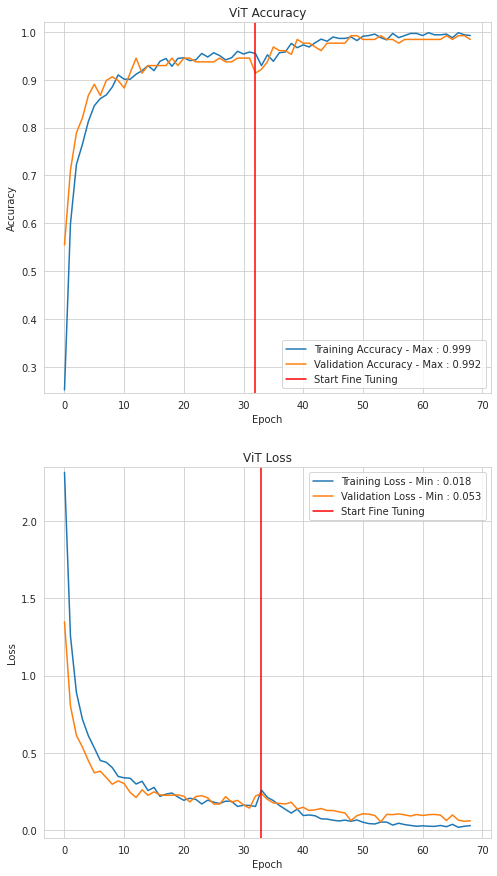

In [ ]:
# Figure initialisation
f, axes = plt.subplots(figsize=(8, 15))

# Accuracy visualization
plt.subplot(211)
plt.plot(hist_vit_df_all['accuracy'], 
         label="Training Accuracy - Max : {:.3f}".format(
             np.max(hist_vit_df_all['accuracy'])))
plt.plot(hist_vit_df_all['val_accuracy'], 
         label="Validation Accuracy - Max : {:.3f}".format(
         np.max(hist_vit_df_all['val_accuracy'])))
plt.plot([len(hist_vit_df)-1,len(hist_vit_df)-1],
          plt.ylim(), label='Start Fine Tuning', color = 'r')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0.245, 1.02)
plt.legend()
plt.title("{} Accuracy".format("ViT"))

# Loss visualization
plt.subplot(212)
plt.plot(hist_vit_df_all['loss'], label="Training Loss - Min : {:.3f}".format(
    np.min(hist_vit_df_all['loss'])))
plt.plot(hist_vit_df_all['val_loss'], 
         label="Validation Loss - Min : {:.3f}".format(
         np.min(hist_vit_df_all['val_loss'])))
plt.plot([len(hist_vit_df),len(hist_vit_df)],
          plt.ylim(), label='Start Fine Tuning', color = 'r')
plt.title("{} Loss".format("ViT"))
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(-0.05, 2.35)
plt.legend()
plt.show()

#### **Evaluation du modèle**
Nous évaluons le modèle sur le jeu de test.

In [ ]:
# Create iterator for testset
test_iterator = datagen.flow_from_directory(test_path,
                                            target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle = False,
                                            seed = 42)

Found 150 images belonging to 10 classes.


In [ ]:
# Model evaluation
model_vit_eval = model_vit.evaluate(test_iterator, 
                                          steps=test_size // BATCH_SIZE)
print("Loss on test set = ", model_vit_eval[0])
print("Accuracy on test set = ",model_vit_eval[1])

4/4 [==============================] - 2s 430ms/step - loss: 0.1858 - accuracy: 0.9531
Loss on test set =  0.18578967452049255
Accuracy on test set =  0.953125


In [ ]:
# Add results to dataframe 
df_results = df_results.append(pd.Series(["Fine tuned ViT",
                                          len(hist_df_vit_tuned),
                                          round(np.max(hist_df_vit_tuned["accuracy"]),4),
                                          round(np.min(hist_df_vit_tuned["loss"]),4),
                                          round(np.max(hist_df_vit_tuned["val_accuracy"]),4),
                                          round(np.min(hist_df_vit_tuned["val_loss"]),4),
                                          round(model_vit_eval[1],4),
                                          round(model_vit_eval[0],4)],
                                         index=df_results.columns), 
                               ignore_index=True)
                              
df_results

Model  Nb epochs  Max Training Accuracy  \
0             MobileNetV2         50                 0.9865   
1  Fine tuned MobileNetV2         51                 1.0000   
2                     ViT         33                 0.9596   
3          Fine tuned ViT         36                 0.9985   

   Min Training Loss  Max Validation Accuracy  Min Validation Loss  \
0             0.0932                   0.9297               0.2820   
1             0.0097                   0.9219               0.2778   
2             0.1528                   0.9453               0.1420   
3             0.0178                   0.9922               0.0529   

   Test Accuracy  Test Loss  
0         0.8750     0.4453  
1         0.9141     0.4318  
2         0.9219     0.3295  
3         0.9531     0.1858

In [ ]:
# Save this dataframe 
filename = models_path + '/df_results_1_bis.joblib'
joblib.dump(df_results, filename)

['/content/drive/My Drive/Formation/POC/models/df_results_1_bis.joblib']

### **6.5. Visualisation d'une image avec mécanisme d'attention**
(sur le modèle importé)

In [ ]:
# It is necessary to reload model if session has been deconnected
nb_classes = 10
SIZE = 224

imported_vit_model = vit.vit_b32(
        image_size = SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = nb_classes)

353263616/353253686 [==============================] - 207s 1us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


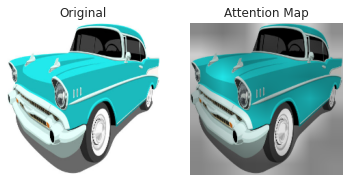

In [ ]:
from vit_keras import visualize, utils

image = utils.read(car_img_path, 224)

attention_map = visualize.attention_map(model = imported_vit_model, 
                                        image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [ ]:
from vit_keras import visualize, utils

list_paths = []
# For each class
for i in range(10):
  # Get class list of images
  images = os.listdir(test_path + "/" + list_classes[i])
 
  # Random index
  x = np.random.randint(0, len(images))
  path = test_path + "/" + list_classes[i] +  "/" + images[x]
  list_paths.append(path)
list_paths

['/content/drive/My Drive/Formation/POC/Sets/TestSet/Cat/00000082.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Tiger/00000106.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Panda/00000088.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Pengouin/00000011.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Flower/00000028.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Bird/00000017.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Tree/00001000.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Plane/00000063.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Dog/00001100.jpg',
 '/content/drive/My Drive/Formation/POC/Sets/TestSet/Car/00001002.jpg']

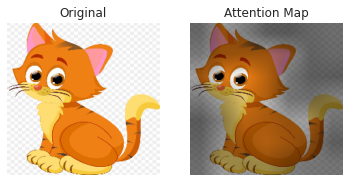

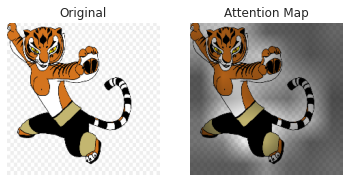

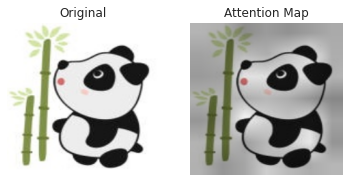

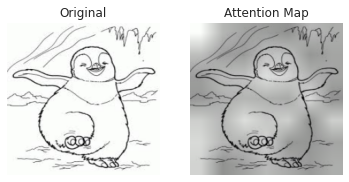

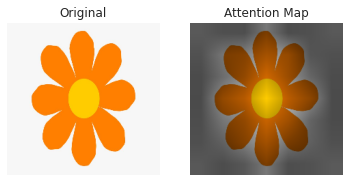

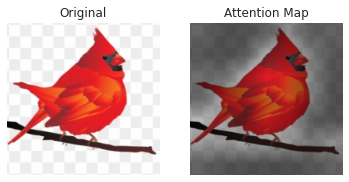

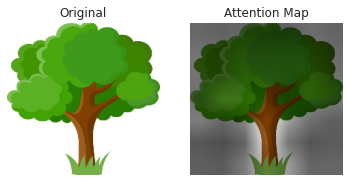

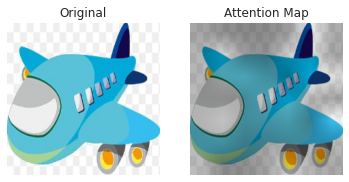

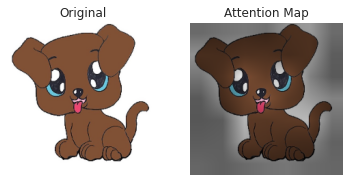

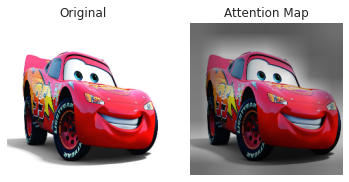

In [ ]:
for path in list_paths :

  image = utils.read(path, 224)
  attention_map = visualize.attention_map(model = imported_vit_model, 
                                        image = image)

  # Plot results
  fig, (ax1, ax2) = plt.subplots(ncols = 2)
  ax1.axis('off')
  ax2.axis('off')
  ax1.set_title('Original')
  ax2.set_title('Attention Map')
  _ = ax1.imshow(image)
  _ = ax2.imshow(attention_map)

## **7. Comparaison des résultats**

### **7.1. Comparaisons des accuracies et losses**

In [ ]:
def evolution_metrics(metrics, list_metrics, location) :
    
    # Figure initialization
    ax = df_results.plot(x="Model", y=list_metrics, kind="bar", figsize=(18,6))
    plt.ylabel(metrics, size = 14)
    plt.xlabel('Model', size = 14)
    ax.set_xticklabels(df_results['Model'].unique(),  size=13, rotation = 0)
    
    # Labels to get metrics values
    for p in ax.patches: 
        ax.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=11)
        
    plt.title("Evolution of {}".format(metrics), size = 14)
    plt.legend(loc = location)
    plt.show()

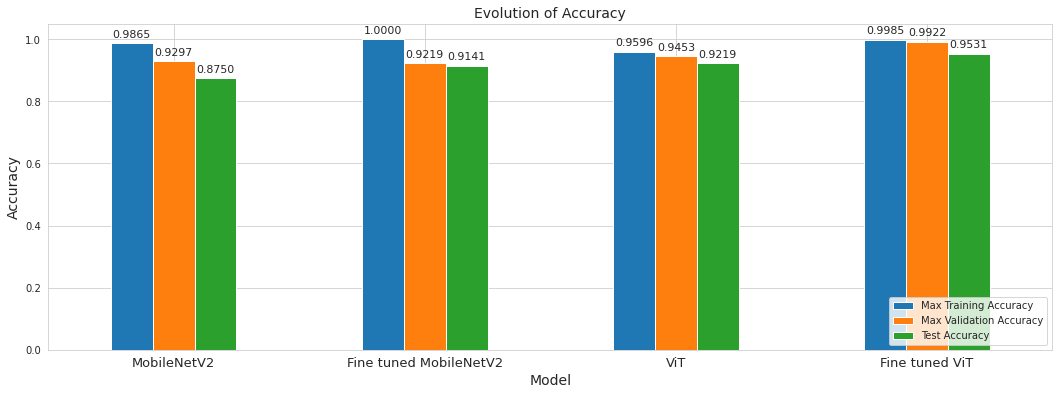

In [ ]:
metrics = "Accuracy"
list_metrics = ["Max Training Accuracy",
                "Max Validation Accuracy",
                "Test Accuracy"]
location = "lower right"

evolution_metrics(metrics,list_metrics, location)

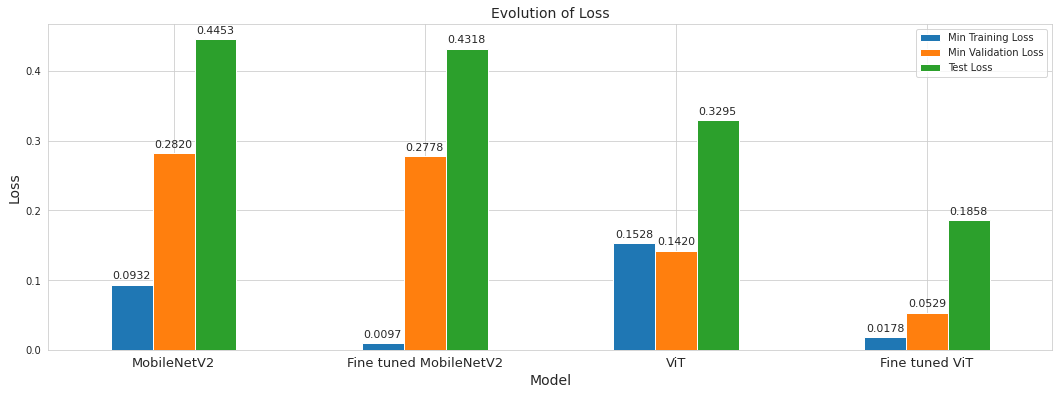

In [ ]:
metrics = "Loss"
list_metrics = ["Min Training Loss",
                "Min Validation Loss",
                "Test Loss"]
location = "upper right"

evolution_metrics(metrics,list_metrics, location)

### **7.2. Comparaison des Prédictions**

#### **Récupération des labels "classes prédites"**

In [ ]:
tf.keras.backend.clear_session()

# Load MobileNetV2 models
models_path = project_path + "/models"
model_MobileNetV2_file_path = models_path + "/model_MobileNetV2_1_bis.h5"
model_MobileNetV2 = keras.models.load_model(model_MobileNetV2_file_path)
model_MobileNetV2_tun_file_path = models_path + "/model_MobileNetV2_2_bis.h5"
model_MobileNetV2_tun = keras.models.load_model(model_MobileNetV2_tun_file_path)

Pour pouvoir charger les modèles ViT, il faut que la session ait en mémoire un modèle vit_b32 importé.

In [ ]:
from vit_keras import vit

# Load ViT models
model_vit_file_path = models_path + "/model_ViT_1.h5"
model_vit = keras.models.load_model(model_vit_file_path)
model_vit_tun_file_path = models_path + "/model_ViT_2_bis.h5"
model_vit_tun = keras.models.load_model(model_vit_tun_file_path)

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input

SIZE = 224
BATCH_SIZE = 32

datagen_mob = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create iterator for testset 
test_mob_iterator = datagen_mob.flow_from_directory(test_path,
                                            target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle = False,
                                            seed = 42)

Found 150 images belonging to 10 classes.


In [ ]:
datagen_vit = ImageDataGenerator(preprocessing_function = vit.preprocess_inputs)

# Create iterator for testset
test_vit_iterator = datagen_vit.flow_from_directory(test_path,
                                            target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle = False,
                                            seed = 42)

Found 150 images belonging to 10 classes.


In [ ]:
# Get predictions MobileNetV2
pred_mob = model_MobileNetV2.predict(test_mob_iterator)
pred_mob_tun = model_MobileNetV2_tun.predict(test_mob_iterator)

In [ ]:
# Get predictions ViT
pred_vit = model_vit.predict(test_vit_iterator)
pred_vit_tun = model_vit_tun.predict(test_vit_iterator)

In [ ]:
# Get predicted classes array MobileNetV2
pred_mob_classes = np.argmax(pred_mob, axis=1)
pred_mob_tun_classes = np.argmax(pred_mob_tun, axis=1)

# Get actual classes array 
actual_mob_classes = test_mob_iterator.labels

In [ ]:
# Get predicted classes array ViT
pred_vit_classes = np.argmax(pred_vit, axis=1)
pred_vit_tun_classes = np.argmax(pred_vit_tun, axis=1)

# Get actual classes array
actual_vit_classes = test_vit_iterator.labels

In [ ]:
# Get list of classes from test_iterator.class_indices dictionnary 
list_classes_it_mob = [k.split("-")[-1] for k in test_mob_iterator.class_indices.keys()]
list_classes_it_mob

['Bird',
 'Car',
 'Cat',
 'Dog',
 'Flower',
 'Panda',
 'Pengouin',
 'Plane',
 'Tiger',
 'Tree']

In [ ]:
# Get list of classes from test_iterator.class_indices dictionnary 
list_classes_it_vit = [k.split("-")[-1] for k in test_vit_iterator.class_indices.keys()]
list_classes_it_vit

['Bird',
 'Car',
 'Cat',
 'Dog',
 'Flower',
 'Panda',
 'Pengouin',
 'Plane',
 'Tiger',
 'Tree']

Nous affichons aléatoirement 10 images avec leur véritable classe et la classe prédite par les différents modèles, accompagnés de la probabilité associée.

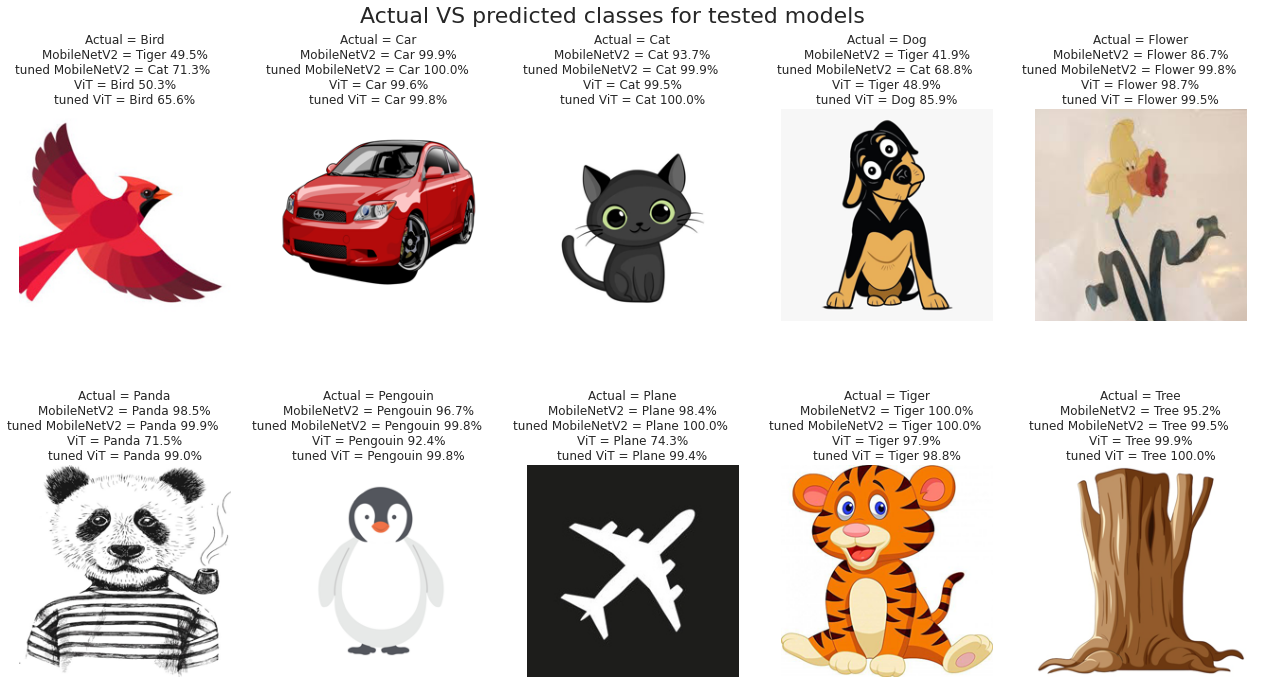

In [ ]:
# Display all classes with 1 image each and total number of images
fig = plt.figure(1, figsize=(22,12))
plt.suptitle("Actual VS predicted classes for tested models", 
             y = 0.95, fontsize=22)

# Iniate counters
j = 0
y = 0

# For each class
for i in range(10):
  # Subplot
  ax = plt.subplot(2, 5, j + 1)
  # Get class list of images
  images = os.listdir(test_path + "/" + list_classes_it_mob[i])
 
  # Random index
  x = np.random.randint(0, len(images))
  img = Image.open(
        test_path + "/" + list_classes_it_mob[i] +  "/" + images[x])
  img = img.resize((224, 224))

  plt.title(
      'Actual = {}\nMobileNetV2 = {} {}%\ntuned MobileNetV2 = {} {}%\
      \nViT = {} {}%\ntuned ViT = {} {}%'.format(
          list_classes_it_mob[actual_mob_classes[x+y]], 
          list_classes_it_mob[pred_mob_classes[x+y]], 
          round(np.max(pred_mob[x+y])*100,1),
          list_classes_it_mob[pred_mob_tun_classes[x+y]],
          round(np.max(pred_mob_tun[x+y])*100,1),
          list_classes_it_vit[pred_vit_classes[x+y]],
          round(np.max(pred_vit[x+y])*100,1),
          list_classes_it_vit[pred_vit_tun_classes[x+y]],
          round(np.max(pred_vit_tun[x+y])*100,1)
          ))
  j+=1
  y += len(images)
  plt.xticks([]) , plt.yticks([])
  plt.imshow(img)
  plt.axis("off")

#### **Analyse des prédictions**
Nous visualisons les résultats via une matrice de confusion et un classification report.

##### ***MobileNetV2***

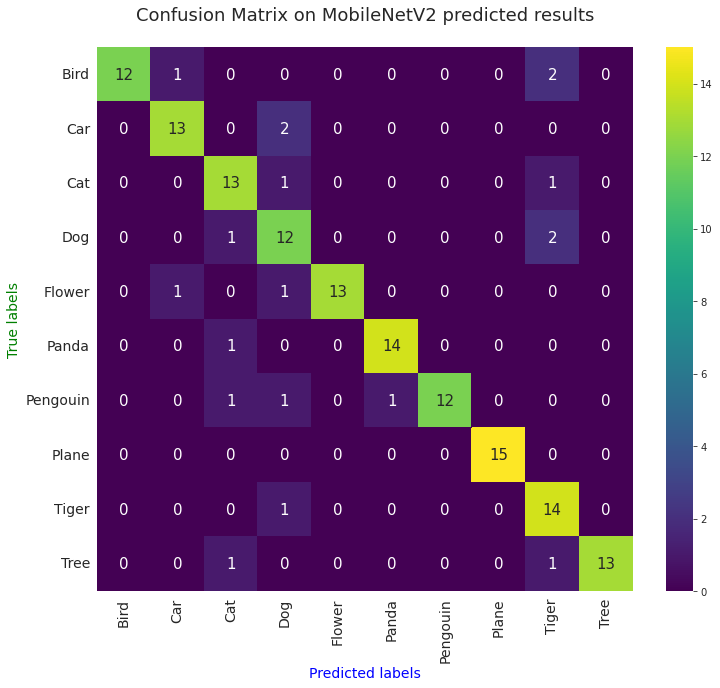

In [ ]:
# Compute confusion matrix
conf_matrix_mob = confusion_matrix(actual_mob_classes, pred_mob_classes)

# Display confusion matrix as a heatmap
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(conf_matrix_mob, annot=True, cmap = "viridis",
                 annot_kws={'size': 15})
ax.set_xlabel("Predicted labels", color="blue", fontsize=14)
ax.set_ylabel("True labels", color="g", fontsize=14)
ax.xaxis.set_ticklabels(list_classes_it_mob, 
                        rotation='vertical', fontsize = 14)
ax.yaxis.set_ticklabels(list_classes_it_mob,
                        rotation='horizontal', fontsize = 14)
plt.title("Confusion Matrix on MobileNetV2 predicted results\n",
          fontsize=18)
plt.show()

In [ ]:
# Display classification report
print(classification_report(actual_mob_classes, pred_mob_classes, 
                            target_names=list_classes_it_mob))

              precision    recall  f1-score   support

        Bird       1.00      0.80      0.89        15
         Car       0.87      0.87      0.87        15
         Cat       0.76      0.87      0.81        15
         Dog       0.67      0.80      0.73        15
      Flower       1.00      0.87      0.93        15
       Panda       0.93      0.93      0.93        15
    Pengouin       1.00      0.80      0.89        15
       Plane       1.00      1.00      1.00        15
       Tiger       0.70      0.93      0.80        15
        Tree       1.00      0.87      0.93        15

    accuracy                           0.87       150
   macro avg       0.89      0.87      0.88       150
weighted avg       0.89      0.87      0.88       150



In [ ]:
# Save this classification_report 
filename = models_path + '/classification_report_mob.joblib'

clf_mob = classification_report(actual_mob_classes, pred_mob_classes, 
                            target_names=list_classes_it_mob, output_dict=True)
joblib.dump(clf_mob, filename)

['/content/drive/My Drive/Formation/POC/models/classification_report_mob.joblib']

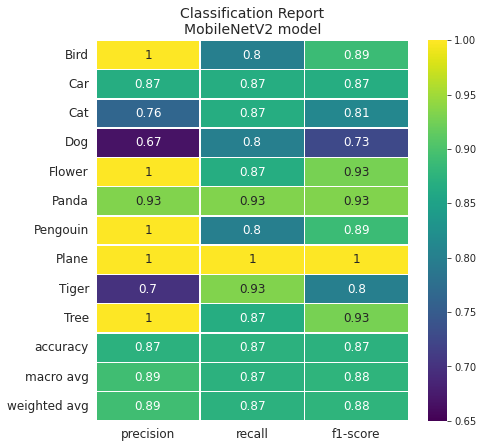

In [ ]:
# Display classification repart as a heatmap
df_mob = pd.DataFrame(clf_mob)

fig = plt.figure(figsize=(7,7))
g = sns.heatmap(df_mob.iloc[:-1, :].T, annot=True, cmap ="viridis",
            linewidths=.5, annot_kws={'size': 12}, vmin = 0.65, vmax = 1)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
plt.title("Classification Report\nMobileNetV2 model", size = 14)
plt.show()

##### ***Tuned MobileNetV2***

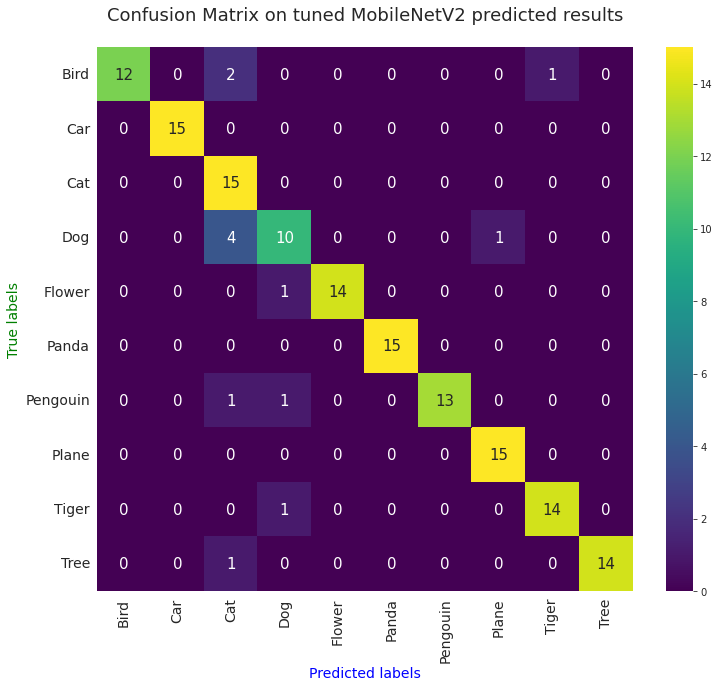

In [ ]:
# Compute confusion matrix on tuned MobileNetV2
conf_matrix_mob_tun = confusion_matrix(actual_mob_classes, pred_mob_tun_classes)

# Display confusion matrix as a heatmap
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(conf_matrix_mob_tun, annot=True, cmap = "viridis",
                 annot_kws={'size': 15})
ax.set_xlabel("Predicted labels", color="blue", fontsize=14)
ax.set_ylabel("True labels", color="g", fontsize=14)
ax.xaxis.set_ticklabels(list_classes_it_mob, 
                        rotation='vertical', fontsize = 14)
ax.yaxis.set_ticklabels(list_classes_it_mob,
                        rotation='horizontal', fontsize = 14)
plt.title("Confusion Matrix on tuned MobileNetV2 predicted results\n",
          fontsize=18)
plt.show()

In [ ]:
# Display classification report on tuned MobileNetV2
print(classification_report(actual_mob_classes, pred_mob_tun_classes, 
                            target_names=list_classes_it_mob))

              precision    recall  f1-score   support

        Bird       1.00      0.80      0.89        15
         Car       1.00      1.00      1.00        15
         Cat       0.65      1.00      0.79        15
         Dog       0.77      0.67      0.71        15
      Flower       1.00      0.93      0.97        15
       Panda       1.00      1.00      1.00        15
    Pengouin       1.00      0.87      0.93        15
       Plane       0.94      1.00      0.97        15
       Tiger       0.93      0.93      0.93        15
        Tree       1.00      0.93      0.97        15

    accuracy                           0.91       150
   macro avg       0.93      0.91      0.92       150
weighted avg       0.93      0.91      0.92       150



Le fined tuning pour MobileNetV2 a amélioré les scores de la diagonale, sauf pour la classe "Dog" : la precision de cette classe s'est faite au détriment au détriment de son recall, entrainement une baisse du score de f1.

Pour la classe "Bird", les métriques n'ont pas changé, par contre les erreurs ne portent plus tout à fait sur les mêmes classes : avant 1 "Car" et 2 "Tiger",maintenant 2 "Cat" et 1 "Tiger".

2 classes ont des scores parfaits : "Car" et "Panda"

In [ ]:
# Save this classification_report 
filename = models_path + '/classification_report_mob_tun.joblib'
clf_mob_tun = classification_report(actual_mob_classes, pred_mob_tun_classes, 
                            target_names=list_classes_it_mob, output_dict=True)

joblib.dump(clf_mob_tun, filename)

['/content/drive/My Drive/Formation/POC/models/classification_report_mob_tun.joblib']

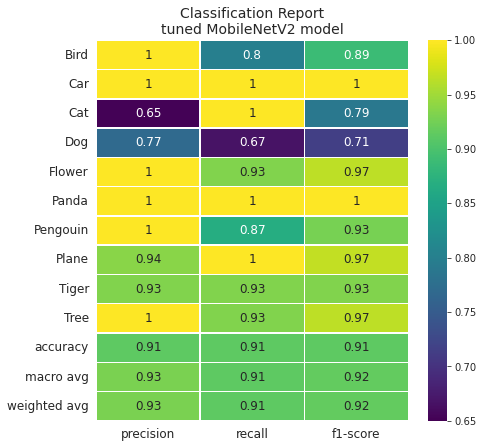

In [ ]:
# Display classification repart as a heatmap
df_mob_tun = pd.DataFrame(clf_mob_tun)

fig = plt.figure(figsize=(7,7))
g = sns.heatmap(df_mob_tun.iloc[:-1, :].T, annot=True, cmap ="viridis", 
            linewidths=.5, annot_kws={'size': 12}, vmin = 0.65, vmax = 1)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
plt.title("Classification Report\ntuned MobileNetV2 model", size = 14)
plt.show()

##### ***ViT***

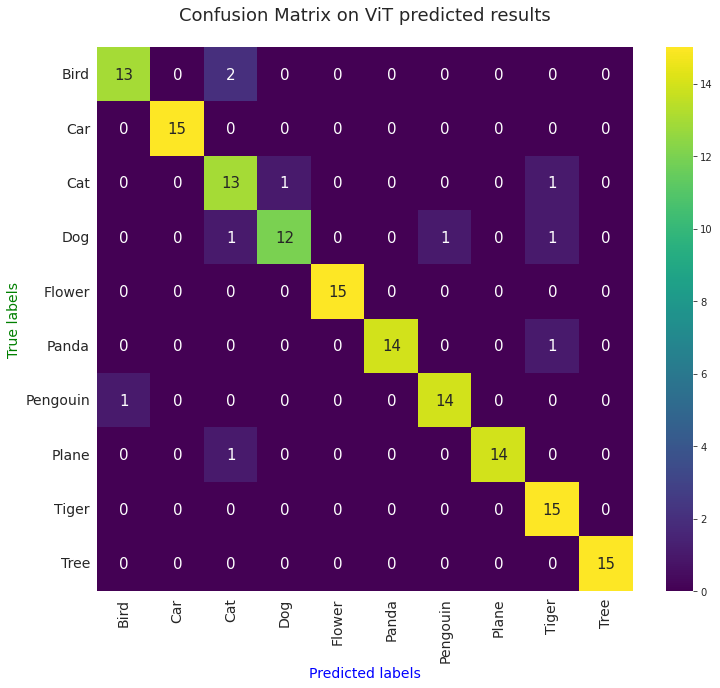

In [ ]:
# Compute confusion matrix for ViT
conf_matrix_vit = confusion_matrix(actual_vit_classes, pred_vit_classes)

# Display confusion matrix as a heatmap
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(conf_matrix_vit, annot=True, cmap = "viridis",
                 annot_kws={'size': 15})
ax.set_xlabel("Predicted labels", color="blue", fontsize=14)
ax.set_ylabel("True labels", color="g", fontsize=14)
ax.xaxis.set_ticklabels(list_classes_it_vit, 
                        rotation='vertical', fontsize = 14)
ax.yaxis.set_ticklabels(list_classes_it_vit,
                        rotation='horizontal', fontsize = 14)
plt.title("Confusion Matrix on ViT predicted results\n",
          fontsize=18)
plt.show()

In [ ]:
# Display classification report
print(classification_report(actual_vit_classes, pred_vit_classes, 
                            target_names=list_classes_it_vit))

              precision    recall  f1-score   support

        Bird       0.93      0.87      0.90        15
         Car       1.00      1.00      1.00        15
         Cat       0.76      0.87      0.81        15
         Dog       0.92      0.80      0.86        15
      Flower       1.00      1.00      1.00        15
       Panda       1.00      0.93      0.97        15
    Pengouin       0.93      0.93      0.93        15
       Plane       1.00      0.93      0.97        15
       Tiger       0.83      1.00      0.91        15
        Tree       1.00      1.00      1.00        15

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.94      0.93      0.93       150



In [ ]:
# Save this classification_report 
filename = models_path + '/classification_report_vit.joblib'

clf_vit = classification_report(actual_vit_classes, pred_vit_classes, 
                            target_names=list_classes_it_vit, output_dict=True)
joblib.dump(clf_vit, filename)

['/content/drive/My Drive/Formation/POC/models/classification_report_vit.joblib']

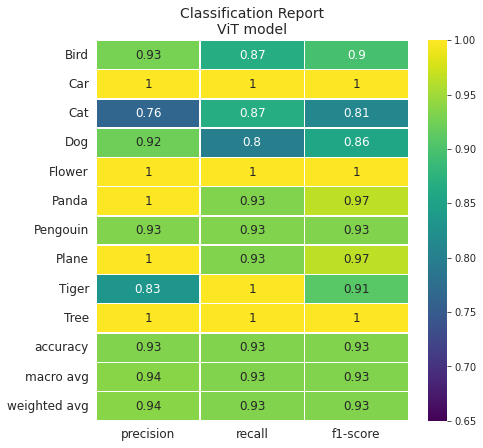

In [ ]:
# Display classification repart as a heatmap
df_vit = pd.DataFrame(clf_vit)

fig = plt.figure(figsize=(7,7))
g = sns.heatmap(df_vit.iloc[:-1, :].T, annot=True, cmap ="viridis",
            linewidths=.5, annot_kws={'size': 12}, vmin = 0.65, vmax = 1)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
plt.title("Classification Report\nViT model", size = 14)
plt.show()

##### ***Tuned ViT***

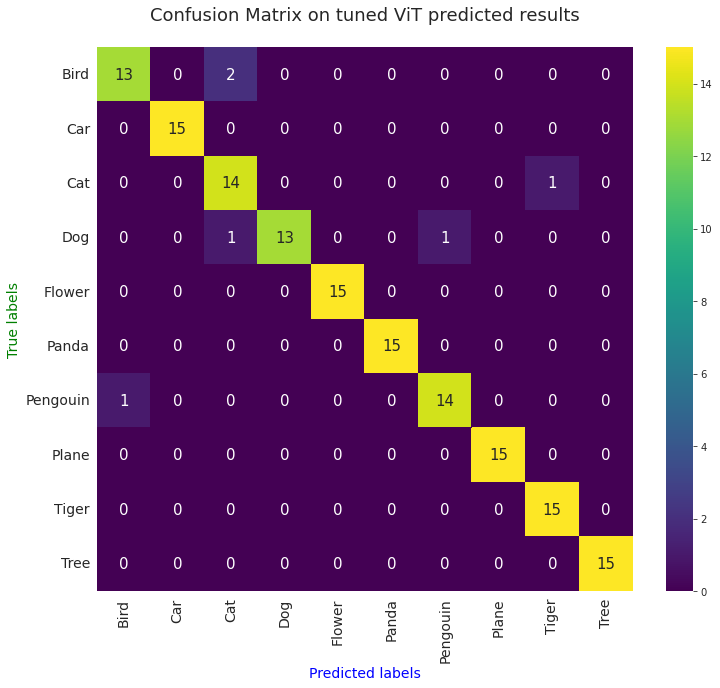

In [ ]:
# Compute confusion matrix for tuned ViT
conf_matrix_vit_tun = confusion_matrix(actual_vit_classes, pred_vit_tun_classes)

# Display confusion matrix as a heatmap
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(conf_matrix_vit_tun, annot=True, cmap = "viridis",
                 annot_kws={'size': 15})
ax.set_xlabel("Predicted labels", color="blue", fontsize=14)
ax.set_ylabel("True labels", color="g", fontsize=14)
ax.xaxis.set_ticklabels(list_classes_it_vit, 
                        rotation='vertical', fontsize = 14)
ax.yaxis.set_ticklabels(list_classes_it_vit,
                        rotation='horizontal', fontsize = 14)
plt.title("Confusion Matrix on tuned ViT predicted results\n",
          fontsize=18)
plt.show()

In [ ]:
# Display classification report
print(classification_report(actual_vit_classes, pred_vit_tun_classes, 
                            target_names=list_classes_it_vit))

              precision    recall  f1-score   support

        Bird       0.93      0.87      0.90        15
         Car       1.00      1.00      1.00        15
         Cat       0.82      0.93      0.87        15
         Dog       1.00      0.87      0.93        15
      Flower       1.00      1.00      1.00        15
       Panda       1.00      1.00      1.00        15
    Pengouin       0.93      0.93      0.93        15
       Plane       1.00      1.00      1.00        15
       Tiger       0.94      1.00      0.97        15
        Tree       1.00      1.00      1.00        15

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



Nous obtenons 5 classes avec des scores parfaits.

In [ ]:
# Save this classification_report 
filename = models_path + '/classification_report_vit_tun.joblib'

clf_vit_tun = classification_report(actual_vit_classes, pred_vit_tun_classes, 
                            target_names=list_classes_it_vit, output_dict=True)
joblib.dump(clf_vit_tun, filename)

['/content/drive/My Drive/Formation/POC/models/classification_report_vit_tun.joblib']

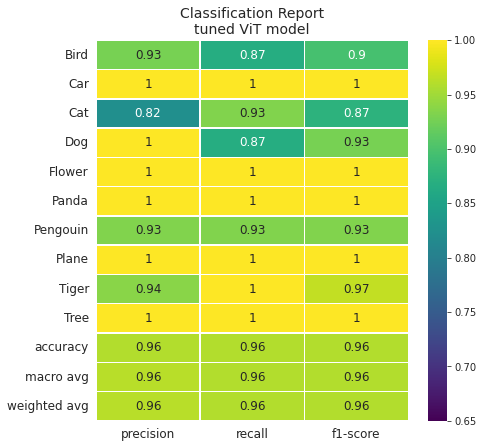

In [ ]:
# Display classification repart as a heatmap
df_vit_tun = pd.DataFrame(clf_vit_tun)

fig = plt.figure(figsize=(7,7))
g = sns.heatmap(df_vit_tun.iloc[:-1, :].T, annot=True, cmap ="viridis",
            linewidths=.5, annot_kws={'size': 12}, vmin = 0.65, vmax = 1)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
plt.title("Classification Report\ntuned ViT model", size = 14)
plt.show()

Le fined tuning  a amélioré les scores de la diagonale.

5 classes ont des scores parfaits : "Car", "Flower", "Panda", "Plane" et "Tree".